<a href="https://colab.research.google.com/github/yrasool/NEURAL-NETWORK/blob/main/AutoencoderLRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

# Global parameters
minibatch_size = 50
learning_rate = 0.001
beta = 0.1
## model 1
size_input = 784 # MNIST data input (img shape: 28*28)
size_hidden = 64

size_output = 10
gamma = 1.0

class Encoder:
    def __init__(self, input_size, encoding_dim):
        # Define sizes
        self.size_input = input_size
        self.size_hidden = 64
        self.size_output = encoding_dim

        # Initialize weights and biases
        self.w1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1), trainable=True, name="W1")
        self.b1 = tf.Variable(tf.zeros([self.size_hidden]), name='b1')
        self.w2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output], stddev=0.1), trainable=True, name='W2')
        self.b2 = tf.Variable(tf.zeros([self.size_output]), name='encoder_b2')

        # Initialize feedback weights
        self.E2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], stddev=1.0), name="E2")
        self.E3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], stddev=1.0), name="E3")

    def compute_output(self, x):
        #print(f"w1:, {self.w1.shape}")
        #print(f"b1:,{self.b1.shape}")
        z1 = tf.matmul(x, self.w1) + self.b1
        a1 = tf.nn.relu(z1)
        #print("[forward] a1 shape (after ReLU):", a1.shape)

        #print(f"w2:, {self.w2.shape}")
        #print(f"b2:,{self.b2.shape}")
        z2 = tf.matmul(a1, self.w2) + self.b2
        #print("[forward] z2 shape:", z2.shape)
        a2 = tf.nn.relu(z2)

        return {
            'layer1_pre_activation': z1,
            'layer1_activation': a1,
            'layer2_pre_activation': z2,
            'layer2_activation': a2,
            'final_encoding': a2
        }

    def __call__(self, x):
        return self.compute_output(x)['final_encoding']

    @property
    def variables(self):
        return [self.w1,  self.w2,  self.E2, self.E3]

class Decoder:
    def __init__(self, encoding_dim, output_size):
        # Define sizes
        self.size_input = encoding_dim
        self.size_hidden = 64
        self.size_output = output_size

        # Initialize weights and biases
        self.w3 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1), trainable=True, name="W3")
        self.b3 = tf.Variable(tf.zeros([self.size_hidden]), name='b3')
        self.w4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output], stddev=0.1), trainable=True, name='W4')
        self.b4 = tf.Variable(tf.zeros([self.size_output]), name='decoder_b4')

        self.E4 = tf.Variable(tf.random.normal([self.size_output, self.size_hidden], stddev=1.0), name="E4")

    def compute_output(self, encoded):
        #print(f"w3: {self.w3.shape}")
        #print(f"b3:,{self.b3.shape}")
        z3 = tf.matmul(encoded, self.w3) + self.b3
        #print("[forward] z3 shape:", z3.shape)
        a3 = tf.nn.relu(z3)
        #print(f"w4:, {self.w4.shape}")
        #print(f"b4:,{self.b4.shape}")
        z4 = tf.matmul(a3, self.w4) + self.b4
        #print("[forward] z4 shape:", z4.shape)
        reconstruction = tf.nn.sigmoid(z4)

        return {
            'layer1_pre_activation': z3,
            'layer1_activation': a3,
            'layer2_pre_activation': z4,
            'final_reconstruction': reconstruction
        }

    def __call__(self, x):
        return self.compute_output(x)['final_reconstruction']

    @property
    def variables(self):
        return [self.w3, self.w4, self.E4]

class Autoencoder:
    def __init__(self, input_size, encoding_dim):
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

        # Initialize storage for intermediate values
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None
        self.z3 = None
        self.a3 = None
        self.decoder_outputs = None
        self.hhat1 = None  # Will store target representations

    def encode_and_decode(self, x):
        # Forward pass
        encoder_outputs = self.encoder.compute_output(x)
        decoder_outputs = self.decoder.compute_output(encoder_outputs['final_encoding'])

        # Store activations for LRA updates
        self.z1 = encoder_outputs['layer1_pre_activation']
        self.a1 = encoder_outputs['layer1_activation']
        self.z2 = encoder_outputs['layer2_pre_activation']
        self.a2 = encoder_outputs['layer2_activation']
        self.z3 = decoder_outputs['layer1_pre_activation']
        self.a3 = decoder_outputs['layer1_activation']
        self.decoder_outputs = decoder_outputs['final_reconstruction']

        return {
            'encoder_outputs': encoder_outputs,
            'decoder_outputs': decoder_outputs,
            'final_reconstruction': decoder_outputs['final_reconstruction']
        }

    def __call__(self, x):
        return self.encode_and_decode(x)['final_reconstruction']

    @property
    def variables(self):
       return [
        self.encoder.w1,
        self.encoder.w2,
        self.decoder.w3,
        self.decoder.w4,
        self.encoder.E2,
        self.encoder.E3,
        self.decoder.E4
      ]


    def compute_loss(self, x_train):
        reconstruction_error = tf.subtract(self.decoder_outputs, x_train)
        return tf.reduce_mean(tf.square(reconstruction_error))

    def compute_lraupdates(self, x_train):
        # Forward pass first
        self.encode_and_decode(x_train)

        # Compute errors and updates
        e4 = tf.subtract(self.decoder_outputs, x_train)  # (50,784)
        e4_T = tf.transpose(e4)                          # (784,50)

        # Compute d3
        d3 = tf.matmul(tf.transpose(self.decoder.E4), e4_T)  # E4: (784,64) → E4^T: (64,784) @ e4_T: (784,50) → d3: (64,50)
        d3_b = tf.multiply(d3, beta)                        # (64,50)

        # Compute y3_z
        z3_T = tf.transpose(self.z3)                         # z3: (50,64) → z3_T: (64,50)
        y3_z = tf.nn.tanh(tf.subtract(z3_T, d3_b))           # (64,50)

        # Compute e3
        e3 = tf.subtract(self.a2, tf.transpose(y3_z))        # a2: (50,64) - y3_z_T: (50,64) → e3: (50,64)

        # Compute d2
        e3_T = tf.transpose(e3)
        #print(e3_T.shape)
        #print(self.encoder.E3.shape)
        d2 = tf.matmul(self.encoder.E3, e3_T)
        # E3: (64,64) @ e3_T: (64,50) → d2: (64,50)
        d2_b = tf.multiply(d2, beta)                        # (64,50)

        # Compute y2_z
        z2_T = tf.transpose(self.z2)                         # z2: (50,64) → z2_T: (64,50)
        y2_z = tf.nn.tanh(tf.subtract(z2_T, d2_b))           # (64,50)

        # Compute e2
        e2 = tf.subtract(self.a2, tf.transpose(y2_z))     # hhat1: (50,64) - y2_z_T: (50,64) → e2: (50,64)

        # Compute d1
        e2_T = tf.transpose(e2)
        #print(e2.shape)# (64,50)
        d1 = tf.matmul(self.encoder.E2, e2_T)                # E2: (64,64) @ e2_T: (64,50) → d1: (64,50)
        d1_b = tf.multiply(d1, beta)                        # (64,50)

        # Compute y1_z
        z1_T = tf.transpose(self.z1)                         # z1: (50,64) → z1_T: (64,50)
        y1_z = tf.nn.tanh(tf.subtract(z1_T, d1_b))           # (64,50)

        # Compute e1
        e1 = tf.subtract(self.z1, tf.transpose(y1_z))        # z1: (50,64) - y1_z_T: (50,64) → e1: (50,64)

        # Compute weight updates
        dW4 = tf.matmul(e4, self.z3, transpose_a=True)      # e4: (50,784) @ z3: (50,64) with transpose_a=True → (784,64)
        dW3 = tf.matmul(e3, self.z2, transpose_a=True)      # e3: (50,64) @ z2: (50,64) with transpose_a=True → (64,64)
        dW2 = tf.matmul(e2, self.z1, transpose_a=True)      # e2: (50,64) @ z1: (50,64) with transpose_a=True → (64,64)
        dW1 = tf.matmul(e1, x_train, transpose_a=True)      # e1: (50,64) @ x_train: (50,784) with transpose_a=True → (64,784)

        # Compute eligible traces
        dW4_e = tf.multiply(dW4, gamma)

        # (784,64)
        dW3_e = tf.multiply(dW3, gamma)

        dW2_e = tf.multiply(dW2, gamma)


        # Combine gradients
        grads_w = [
            tf.transpose(dW1),  # (784,64) → matches w1: (784,64)
            tf.transpose(dW2),  # (64,64) → matches w2: (64,64)
            tf.transpose(dW3),  # (64,64) → matches w3: (64,64)
            tf.transpose(dW4),  # (64,784) → matches w4: (64,784)
            dW2_e,              # (64,64) → matches E2: (64,64)
            dW3_e,              # (64,64) → matches E3: (64,64)
            dW4_e               # (784,64) → matches E4: (784,64)
        ]
        #for g, v in zip(grads_w, self.variables):
           #print(f"Variable {v.name} shape: {v.shape}, Gradient shape: {g.shape}")


        # Apply updates
        self.optimizer.apply_gradients(zip(grads_w, self.variables))

        # Return current loss
        return self.compute_loss(x_train)
def train_autoencoder():
    # Prepare MNIST dataset
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)

    # Initialize autoencoder
    input_size = 784  # 28*28
    encoding_dim = 64
    autoencoder = Autoencoder(input_size, encoding_dim)

    # Training loop
    epochs = 10
    batch_size = minibatch_size
    n_batches = len(x_train) // batch_size

    for epoch in range(epochs):
        total_loss = 0
        # Shuffle training data
        idx = np.random.permutation(len(x_train))
        x_train_shuffled = x_train[idx]

        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            batch = x_train_shuffled[start_idx:end_idx]

            # Train on batch using LRA updates
            loss = autoencoder.compute_lraupdates(batch)
            total_loss += loss

            #if batch_idx % 10 == 0:
                #print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{n_batches}, Loss: {loss:.4f}")

        # Print epoch results
        avg_loss = total_loss / n_batches
        print(f"Epoch {epoch+1} completed, Average Loss: {avg_loss:.4f}")

        # Evaluate on test set
        test_reconstructions = autoencoder(x_test[:1000])
        test_loss = tf.reduce_mean(tf.square(x_test[:1000] - test_reconstructions))
        print(f"Test Loss: {test_loss:.4f}\n")

if __name__ == "__main__":
    train_autoencoder()


Epoch 1/10, Batch 0/1200, Loss: 0.2312
Epoch 1/10, Batch 10/1200, Loss: 0.2260
Epoch 1/10, Batch 20/1200, Loss: 0.2214
Epoch 1/10, Batch 30/1200, Loss: 0.2099
Epoch 1/10, Batch 40/1200, Loss: 0.1942
Epoch 1/10, Batch 50/1200, Loss: 0.1602
Epoch 1/10, Batch 60/1200, Loss: 0.1184
Epoch 1/10, Batch 70/1200, Loss: 0.0918
Epoch 1/10, Batch 80/1200, Loss: 0.0757
Epoch 1/10, Batch 90/1200, Loss: 0.0761
Epoch 1/10, Batch 100/1200, Loss: 0.0750
Epoch 1/10, Batch 110/1200, Loss: 0.0713
Epoch 1/10, Batch 120/1200, Loss: 0.0741
Epoch 1/10, Batch 130/1200, Loss: 0.0722
Epoch 1/10, Batch 140/1200, Loss: 0.0681
Epoch 1/10, Batch 150/1200, Loss: 0.0695
Epoch 1/10, Batch 160/1200, Loss: 0.0731
Epoch 1/10, Batch 170/1200, Loss: 0.0699
Epoch 1/10, Batch 180/1200, Loss: 0.0709
Epoch 1/10, Batch 190/1200, Loss: 0.0666
Epoch 1/10, Batch 200/1200, Loss: 0.0709
Epoch 1/10, Batch 210/1200, Loss: 0.0675
Epoch 1/10, Batch 220/1200, Loss: 0.0714
Epoch 1/10, Batch 230/1200, Loss: 0.0710
Epoch 1/10, Batch 240/1200,

KeyboardInterrupt: 

Epoch 1 completed
Train Loss: 0.0780, Test Loss: 0.0680

Epoch 2 completed
Train Loss: 0.0714, Test Loss: 0.0732

Epoch 3 completed
Train Loss: 0.0718, Test Loss: 0.0695

Epoch 4 completed
Train Loss: 0.0724, Test Loss: 0.0717

Epoch 5 completed
Train Loss: 0.0728, Test Loss: 0.0707

Epoch 6 completed
Train Loss: 0.0733, Test Loss: 0.0716

Epoch 7 completed
Train Loss: 0.0737, Test Loss: 0.0776

Epoch 8 completed
Train Loss: 0.0739, Test Loss: 0.0735

Epoch 9 completed
Train Loss: 0.0745, Test Loss: 0.0740

Epoch 10 completed
Train Loss: 0.0749, Test Loss: 0.0706



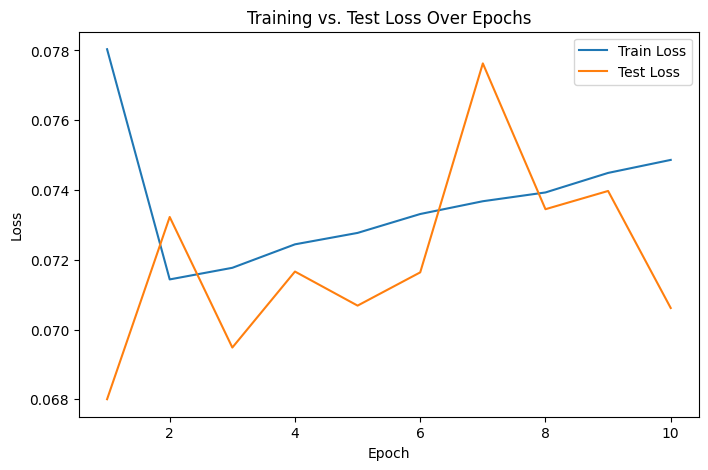

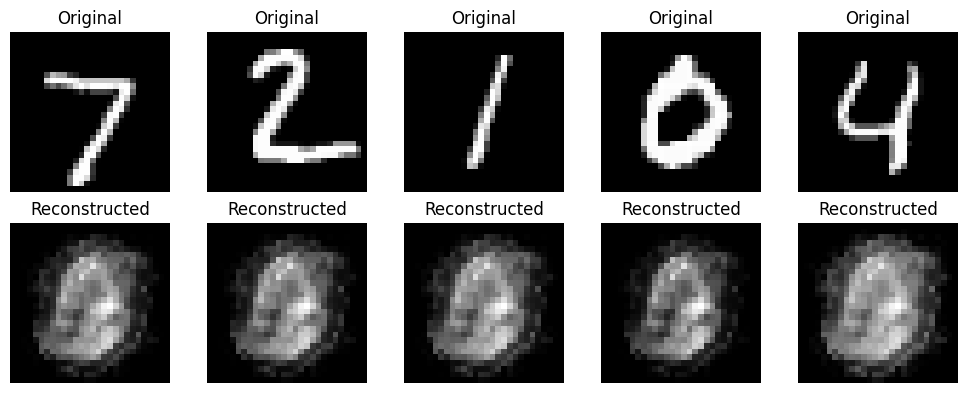

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
# Global parameters
minibatch_size = 50
learning_rate = 0.001
beta = 0.1
## model 1
size_input = 784 # MNIST data input (img shape: 28*28)
size_hidden = 64

size_output = 10
gamma = 1.0

class Encoder:
    def __init__(self, input_size, encoding_dim):
        # Define sizes
        self.size_input = input_size
        self.size_hidden = 64
        self.size_output = encoding_dim

        # Initialize weights and biases
        self.w1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1), trainable=True, name="W1")
        self.b1 = tf.Variable(tf.zeros([self.size_hidden]), name='b1')
        self.w2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output], stddev=0.1), trainable=True, name='W2')
        self.b2 = tf.Variable(tf.zeros([self.size_output]), name='encoder_b2')

        # Initialize feedback weights
        self.E2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], stddev=1.0), name="E2")
        self.E3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], stddev=1.0), name="E3")

    def compute_output(self, x):
        #print(f"w1:, {self.w1.shape}")
        #print(f"b1:,{self.b1.shape}")
        z1 = tf.matmul(x, self.w1) + self.b1
        a1 = tf.nn.relu(z1)
        #print("[forward] a1 shape (after ReLU):", a1.shape)

        #print(f"w2:, {self.w2.shape}")
        #print(f"b2:,{self.b2.shape}")
        z2 = tf.matmul(a1, self.w2) + self.b2
        #print("[forward] z2 shape:", z2.shape)
        a2 = tf.nn.relu(z2)

        return {
            'layer1_pre_activation': z1,
            'layer1_activation': a1,
            'layer2_pre_activation': z2,
            'layer2_activation': a2,
            'final_encoding': a2
        }

    def __call__(self, x):
        return self.compute_output(x)['final_encoding']

    @property
    def variables(self):
        return [self.w1,  self.w2,  self.E2, self.E3]

class Decoder:
    def __init__(self, encoding_dim, output_size):
        # Define sizes
        self.size_input = encoding_dim
        self.size_hidden = 64
        self.size_output = output_size

        # Initialize weights and biases
        self.w3 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1), trainable=True, name="W3")
        self.b3 = tf.Variable(tf.zeros([self.size_hidden]), name='b3')
        self.w4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output], stddev=0.1), trainable=True, name='W4')
        self.b4 = tf.Variable(tf.zeros([self.size_output]), name='decoder_b4')

        self.E4 = tf.Variable(tf.random.normal([self.size_output, self.size_hidden], stddev=1.0), name="E4")

    def compute_output(self, encoded):
        #print(f"w3: {self.w3.shape}")
        #print(f"b3:,{self.b3.shape}")
        z3 = tf.matmul(encoded, self.w3) + self.b3
        #print("[forward] z3 shape:", z3.shape)
        a3 = tf.nn.relu(z3)
        #print(f"w4:, {self.w4.shape}")
        #print(f"b4:,{self.b4.shape}")
        z4 = tf.matmul(a3, self.w4) + self.b4
        #print("[forward] z4 shape:", z4.shape)
        reconstruction = tf.nn.sigmoid(z4)

        return {
            'layer1_pre_activation': z3,
            'layer1_activation': a3,
            'layer2_pre_activation': z4,
            'final_reconstruction': reconstruction
        }

    def __call__(self, x):
        return self.compute_output(x)['final_reconstruction']

    @property
    def variables(self):
        return [self.w3, self.w4, self.E4]

class Autoencoder:
    def __init__(self, input_size, encoding_dim):
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

        # Initialize storage for intermediate values
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None
        self.z3 = None
        self.a3 = None
        self.decoder_outputs = None
        self.hhat1 = None  # Will store target representations

    def encode_and_decode(self, x):
        # Forward pass
        encoder_outputs = self.encoder.compute_output(x)
        decoder_outputs = self.decoder.compute_output(encoder_outputs['final_encoding'])

        # Store activations for LRA updates
        self.z1 = encoder_outputs['layer1_pre_activation']
        self.a1 = encoder_outputs['layer1_activation']
        self.z2 = encoder_outputs['layer2_pre_activation']
        self.a2 = encoder_outputs['layer2_activation']
        self.z3 = decoder_outputs['layer1_pre_activation']
        self.a3 = decoder_outputs['layer1_activation']
        self.decoder_outputs = decoder_outputs['final_reconstruction']

        return {
            'encoder_outputs': encoder_outputs,
            'decoder_outputs': decoder_outputs,
            'final_reconstruction': decoder_outputs['final_reconstruction']
        }

    def __call__(self, x):
        return self.encode_and_decode(x)['final_reconstruction']

    @property
    def variables(self):
       return [
        self.encoder.w1,
        self.encoder.w2,
        self.decoder.w3,
        self.decoder.w4,
        self.encoder.E2,
        self.encoder.E3,
        self.decoder.E4
      ]


    def compute_loss(self, x_train):
        reconstruction_error = tf.subtract(self.decoder_outputs, x_train)
        return tf.reduce_mean(tf.square(reconstruction_error))

    def compute_lraupdates(self, x_train):
        # Forward pass first
        self.encode_and_decode(x_train)

        # Compute errors and updates
        e4 = tf.subtract(self.decoder_outputs, x_train)  # (50,784)
        e4_T = tf.transpose(e4)                          # (784,50)

        # Compute d3
        d3 = tf.matmul(tf.transpose(self.decoder.E4), e4_T)  # E4: (784,64) → E4^T: (64,784) @ e4_T: (784,50) → d3: (64,50)
        d3_b = tf.multiply(d3, beta)                        # (64,50)

        # Compute y3_z
        z3_T = tf.transpose(self.z3)                         # z3: (50,64) → z3_T: (64,50)
        y3_z = tf.nn.tanh(tf.subtract(z3_T, d3_b))           # (64,50)

        # Compute e3
        e3 = tf.subtract(self.a2, tf.transpose(y3_z))        # a2: (50,64) - y3_z_T: (50,64) → e3: (50,64)

        # Compute d2
        e3_T = tf.transpose(e3)
        #print(e3_T.shape)
        #print(self.encoder.E3.shape)
        d2 = tf.matmul(self.encoder.E3, e3_T)
        # E3: (64,64) @ e3_T: (64,50) → d2: (64,50)
        d2_b = tf.multiply(d2, beta)                        # (64,50)

        # Compute y2_z
        z2_T = tf.transpose(self.z2)                         # z2: (50,64) → z2_T: (64,50)
        y2_z = tf.nn.tanh(tf.subtract(z2_T, d2_b))           # (64,50)

        # Compute e2
        e2 = tf.subtract(self.a2, tf.transpose(y2_z))     # hhat1: (50,64) - y2_z_T: (50,64) → e2: (50,64)

        # Compute d1
        e2_T = tf.transpose(e2)
        #print(e2.shape)# (64,50)
        d1 = tf.matmul(self.encoder.E2, e2_T)                # E2: (64,64) @ e2_T: (64,50) → d1: (64,50)
        d1_b = tf.multiply(d1, beta)                        # (64,50)

        # Compute y1_z
        z1_T = tf.transpose(self.z1)                         # z1: (50,64) → z1_T: (64,50)
        y1_z = tf.nn.tanh(tf.subtract(z1_T, d1_b))           # (64,50)

        # Compute e1
        e1 = tf.subtract(self.z1, tf.transpose(y1_z))        # z1: (50,64) - y1_z_T: (50,64) → e1: (50,64)

        # Compute weight updates
        dW4 = tf.matmul(e4, self.z3, transpose_a=True)      # e4: (50,784) @ z3: (50,64) with transpose_a=True → (784,64)
        dW3 = tf.matmul(e3, self.z2, transpose_a=True)      # e3: (50,64) @ z2: (50,64) with transpose_a=True → (64,64)
        dW2 = tf.matmul(e2, self.z1, transpose_a=True)      # e2: (50,64) @ z1: (50,64) with transpose_a=True → (64,64)
        dW1 = tf.matmul(e1, x_train, transpose_a=True)      # e1: (50,64) @ x_train: (50,784) with transpose_a=True → (64,784)

        # Compute eligible traces
        dW4_e = tf.multiply(dW4, gamma)

        # (784,64)
        dW3_e = tf.multiply(dW3, gamma)

        dW2_e = tf.multiply(dW2, gamma)


        # Combine gradients
        grads_w = [
            tf.transpose(dW1),  # (784,64) → matches w1: (784,64)
            tf.transpose(dW2),  # (64,64) → matches w2: (64,64)
            tf.transpose(dW3),  # (64,64) → matches w3: (64,64)
            tf.transpose(dW4),  # (64,784) → matches w4: (64,784)
            dW2_e,              # (64,64) → matches E2: (64,64)
            dW3_e,              # (64,64) → matches E3: (64,64)
            dW4_e               # (784,64) → matches E4: (784,64)
        ]
        #for g, v in zip(grads_w, self.variables):
           #print(f"Variable {v.name} shape: {v.shape}, Gradient shape: {g.shape}")


        # Apply updates
        self.optimizer.apply_gradients(zip(grads_w, self.variables))

        # Return current loss
        return self.compute_loss(x_train)

def visualize_reconstructions(autoencoder, x_test, num_images=5):
    """
    1) Pick 'num_images' images from x_test
    2) Run them through the autoencoder to get reconstructions
    3) Plot original (top row) vs. reconstructed (bottom row)
    """
    x_subset = x_test[:num_images]  # or pick random indices if you want
    recons = autoencoder(x_subset)  # autoencoder forward pass -> reconstruction

    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(x_subset[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstruction
        ax = plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(recons[i].numpy().reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def train_autoencoder():
    # Prepare MNIST dataset
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)

    # Initialize autoencoder
    input_size = 784  # 28*28
    encoding_dim = 64
    autoencoder = Autoencoder(input_size, encoding_dim)

    # Training loop
    epochs = 10
    batch_size = minibatch_size
    n_batches = len(x_train) // batch_size

    # Collect training & validation losses
    train_losses_per_epoch = []
    val_losses_per_epoch = []

    for epoch in range(epochs):
        total_loss = 0.0

        # Shuffle training data each epoch
        idx = np.random.permutation(len(x_train))
        x_train_shuffled = x_train[idx]

        #  Training loop
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            batch = x_train_shuffled[start_idx:end_idx]

            # LRA update
            loss = autoencoder.compute_lraupdates(batch)
            total_loss += loss.numpy()

            #if batch_idx % 10 == 0:
                #print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{n_batches}, Batch Loss: {loss:.4f}")

        #  Average training loss for the epoch
        avg_train_loss = total_loss / n_batches
        train_losses_per_epoch.append(avg_train_loss)

        #  Validation (test) loss
        # first 1000 test samples for speed
        test_subset = 1000
        recon_test = autoencoder(x_test[:test_subset])
        test_loss = tf.reduce_mean(tf.square(x_test[:test_subset] - recon_test)).numpy()
        val_losses_per_epoch.append(test_loss)

        # Print results
        print(f"Epoch {epoch+1} completed")
        print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}\n")

    #  Plot the training and validation (test) loss
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses_per_epoch, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses_per_epoch, label='Test Loss')
    plt.title("Training vs. Test Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    # After training, visualize some reconstructions!
    visualize_reconstructions(autoencoder, x_test, num_images=5)




if __name__ == "__main__":
    train_autoencoder()
